Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [3]:
# unzip the dataset in the mounted drive
!unzip /content/gdrive/MyDrive/Colab_Notebooks/CNN_assignment.zip

Archive:  /content/gdrive/MyDrive/Colab_Notebooks/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.j

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

# image_dataset_from_directory is used to create the image dataset from folder structure. Startercode batch_size, image height and image width
# are used as as the argument. In the below section of the code training data set is created from "Train" folder at 80:20 ratio
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               batch_size=batch_size,
                                                               image_size=(img_height,img_width),
                                                               seed=123, 
                                                               validation_split = 0.2,
                                                               subset="training",
                                                               label_mode='categorical')


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

# image_dataset_from_directory is used to create the image dataset from folder structure. Startercode batch_size, image height and image width
# are used as as the argument. In the below section of the code validation dataset is created from "Train" folder at 80:20 ratio
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               batch_size=batch_size,
                                                               image_size=(img_height,img_width),
                                                               seed=123, 
                                                               validation_split = 0.2,
                                                               subset="validation",
                                                               label_mode='categorical')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

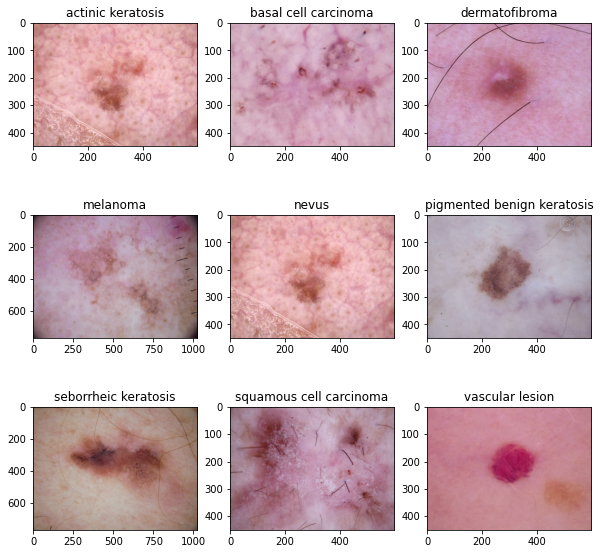

In [10]:
import matplotlib.pyplot as plt
import glob
from skimage.io import imread
### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10,10))
for classess in range(9):
  ax = plt.subplot(3,3,classess+1)
  imagepath = class_names[classess]+'/*'  # create the search string for glob method
  imagepath = list(data_dir_train.glob(imagepath))[0] # pick the very first image from each class
  plt.title(label=class_names[classess]) # title the subplot with class name
  imagedata=imread(imagepath) # read the image
  plt.imshow(imagedata) # plot the image in the subplot grid

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
# model
# Rescaling layer initialized while object is instatiated for the ease of reading
model = Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(img_height, img_width,3))])

# a keras convolutional layer is called Conv2D
# first conv layer with 16 3x3 filters and relu activation function with stride 1
# No reduction in the convoluted image size compared to original using padding
model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(img_height, img_width,3), padding = "same")) 

# second conv layer with 32 3x3 filters and relu activation function with stride 1.  
# No reduction in the convoluted image size compared to original using padding
model.add(Conv2D(32, kernel_size=(3, 3), 
                 activation='relu',padding = "same"))

# 2x2 max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))


# third conv layer with 64 3x3 filter and relu activation function with stride 1
# No reduction in the convoluted image compared to previous max pooling layer usiang padding
model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu',padding = "same"))

# max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

# flatten and put a fully connected layer
model.add(Flatten())

model.add(Dense(128, activation='relu')) # fully connected
#model.add(Dropout(0.5))

# softmax layer
model.add(Dense(9, activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### Todo, choose an appropirate optimiser and loss function

# Compiler confgiured to "adam" optimizer, crossentropy loss function and metrics to be compiled with when fitting is accuracy
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                    

### Train the model

In [15]:
# Training the model as per the epochs specified in the problem statement. batch_size is already set in the dataset
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 25s 105ms/step - loss: 2.5218 - accuracy: 0.2718 - val_loss: 1.8810 - val_accuracy: 0.3289
Epoch 2/20
56/56 [==============================] - 3s 54ms/step - loss: 1.5913 - accuracy: 0.4381 - val_loss: 1.5192 - val_accuracy: 0.5324
Epoch 3/20
56/56 [==============================] - 3s 54ms/step - loss: 1.3864 - accuracy: 0.5151 - val_loss: 1.5061 - val_accuracy: 0.4743
Epoch 4/20
56/56 [==============================] - 3s 54ms/step - loss: 1.2905 - accuracy: 0.5458 - val_loss: 1.5488 - val_accuracy: 0.4810
Epoch 5/20
56/56 [==============================] - 3s 54ms/step - loss: 1.1036 - accuracy: 0.6088 - val_loss: 1.5222 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 3s 55ms/step - loss: 0.9518 - accuracy: 0.6741 - val_loss: 1.6770 - val_accuracy: 0.5056
Epoch 7/20
56/56 [==============================] - 3s 55ms/step - loss: 0.8420 - accuracy: 0.7037 - val_loss: 1.8803 - val_accuracy: 0.5034
Epoch 8/20


### Visualizing training results

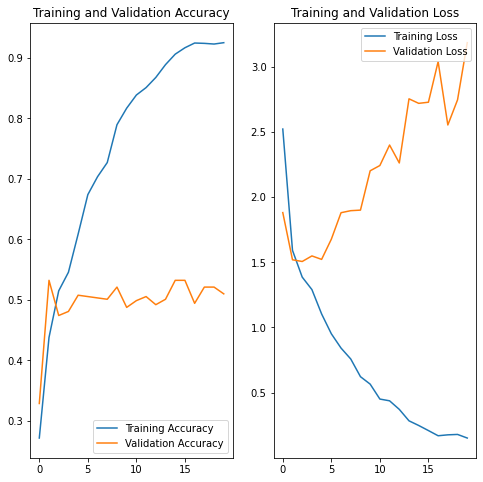

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Findings:
- Training accuracy is very high with an relatively low validation accuracy. This is clear indication of model overfitting the training data set. 
- Since the batch sizes and epochs are already fixed in assignment, dropout hyperparameter could be used to reduce overfitting model.
- Potential hyperparameter tuning would be to delete 25% from the last concolution layer and 50% from the dense layer (accounting redundant connections in the fully connected network). Let us verify the result

In [17]:
# model
# Rescaling layer initialized while object is instatiated for the ease of reading
model = Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(img_height, img_width,3))])

# a keras convolutional layer is called Conv2D
# first conv layer with 16 3x3 filters and relu activation function with stride 1
# No reduction in the convoluted image size compared to original using padding
model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(img_height, img_width,3), padding = "same")) 

# second conv layer with 32 3x3 filters and relu activation function with stride 1.  
# No reduction in the convoluted image size compared to original using padding
model.add(Conv2D(32, kernel_size=(3, 3), 
                 activation='relu',padding = "same"))

# 2x2 max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))


# third conv layer with 64 3x3 filter and relu activation function with stride 1
# No reduction in the convoluted image compared to previous max pooling layer usiang padding
model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu',padding = "same"))

# max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# hyperparameter tuning add 25% percent dropout at the convolution later
model.add(Dropout(0.25))

# flatten and put a fully connected layer
model.add(Flatten())

model.add(Dense(128, activation='relu')) # fully connected

# Hyperparameter tuning: add 50% dropput in fully connected layer as therecould be redundant connections in an dense network
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(9, activation='softmax'))

In [18]:
# Compiler confgiured to "adam" optimizer, crossentropy loss function and metrics to be compiled with when fitting is accuracy
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [19]:
# Training the model as per the epochs specified in the problem statement. batch_size is already set in the dataset
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 60ms/step - loss: 2.3828 - accuracy: 0.2098 - val_loss: 1.8901 - val_accuracy: 0.3535
Epoch 2/20
56/56 [==============================] - 3s 57ms/step - loss: 1.8511 - accuracy: 0.3237 - val_loss: 1.6524 - val_accuracy: 0.4743
Epoch 3/20
56/56 [==============================] - 3s 57ms/step - loss: 1.6881 - accuracy: 0.4085 - val_loss: 1.5807 - val_accuracy: 0.4832
Epoch 4/20
56/56 [==============================] - 3s 57ms/step - loss: 1.6026 - accuracy: 0.4436 - val_loss: 1.4459 - val_accuracy: 0.5414
Epoch 5/20
56/56 [==============================] - 3s 57ms/step - loss: 1.5357 - accuracy: 0.4637 - val_loss: 1.4235 - val_accuracy: 0.5280
Epoch 6/20
56/56 [==============================] - 3s 57ms/step - loss: 1.4160 - accuracy: 0.5151 - val_loss: 1.4410 - val_accuracy: 0.5011
Epoch 7/20
56/56 [==============================] - 3s 57ms/step - loss: 1.3573 - accuracy: 0.5206 - val_loss: 1.4860 - val_accuracy: 0.5347
Epoch 8/20
56

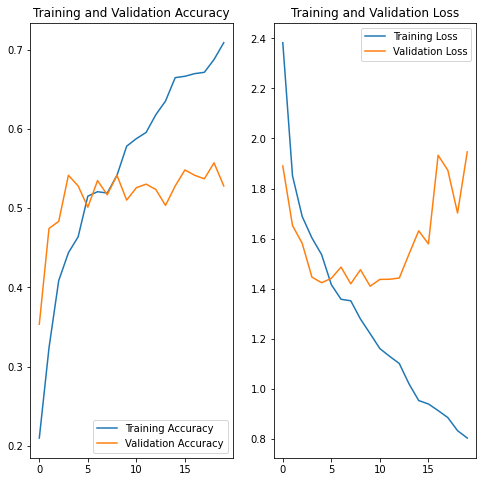

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Above model with dropout underfit the model

In [21]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here


# Data agumentation shall be applied to reduce the overfit of the model. Agumentation strategy is to randomly rotate, flip and zoom.
# Create a model with layers that could agument the input image as per the agumentation strategy

def agument_func(image):
  data_augmentation_model = Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(img_height, img_width,3)),
                                        layers.experimental.preprocessing.RandomFlip('horizontal'),
                                        layers.experimental.preprocessing.RandomRotation(0.1),
                                        layers.experimental.preprocessing.RandomZoom(0.1)]
                                      )
  return data_augmentation_model(image)



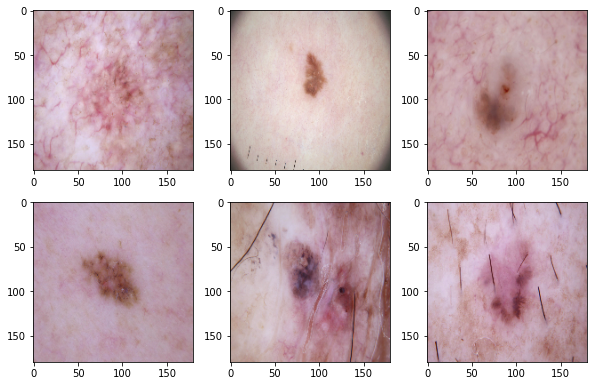

In [22]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

# lets visualize the augmented 6 images
plt.figure(figsize=(10,10))
for image, label in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot (3,3,i+1)
    plt.imshow(agument_func(image)[i].numpy().astype("float32"))

### Todo:
### Create the model, compile and train the model


In [23]:

## You can use Dropout layer if there is an evidence of overfitting in your findings
## Your code goes here


# sequential model instantiation with rescalling first and than the data augmentaion of flip, rotationa and zoom.
# From the documentation it is understood that RandomFlip, randomRotation, RandomZoom methods from preprocessing doesnt change the training
# or validation dataset when inferring/predicting the output. Therefore it can be directly used as layers in the network
data_augmentation_model = Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(img_height, img_width,3)),
                                        layers.experimental.preprocessing.RandomFlip('horizontal'),
                                        layers.experimental.preprocessing.RandomRotation(0.1),
                                        layers.experimental.preprocessing.RandomZoom(0.1)]
                                      )


# a keras convolutional layer is called Conv2D

# first conv layer with 16 3x3 filters and relu activation function with stride 1
# No reduction in the convoluted image size compared to original using padding
data_augmentation_model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(img_height, img_width,3), padding = "same")) # input shape = (img_rows, img_cols, 1)

# second conv layer with 32 3x3 filters and relu activation function with stride 1.  
# No reduction in the convoluted image size compared to original using padding
data_augmentation_model.add(Conv2D(32, kernel_size=(3, 3), 
                 activation='relu',padding = "same"))

# 2x2 max pooling
data_augmentation_model.add(MaxPooling2D(pool_size=(2, 2)))


# third conv layer with 64 3x3 filter and relu activation function with stride 1
# No reduction in the convoluted image compared to previous max pooling layer usiang padding
data_augmentation_model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu',padding = "same"))
# 2x2 max pooling
data_augmentation_model.add(MaxPooling2D(pool_size=(2, 2)))

# hyperparameter tuning add 25% percent dropout at the convolution later
model.add(Dropout(0.25))

# flatten and put a fully connected layer
data_augmentation_model.add(Flatten())

data_augmentation_model.add(Dense(128, activation='relu')) # fully connected

# Hyperparameter tuning: add 50% dropput in fully connected layer as therecould be redundant connections in an dense network
model.add(Dropout(0.5))

# softmax layer
data_augmentation_model.add(Dense(9, activation='softmax'))


### Compiling the model

In [24]:
## Your code goes here

data_augmentation_model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [25]:
data_augmentation_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_flip_6 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_6 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_6 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 conv2d_7 (Conv2D)           (None, 180, 180, 32)      4640      
                                                      

### Training the model

In [26]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = data_augmentation_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 76ms/step - loss: 2.6084 - accuracy: 0.2098 - val_loss: 1.9681 - val_accuracy: 0.2662
Epoch 2/20
56/56 [==============================] - 4s 72ms/step - loss: 1.8999 - accuracy: 0.2902 - val_loss: 1.7542 - val_accuracy: 0.3579
Epoch 3/20
56/56 [==============================] - 4s 72ms/step - loss: 1.8320 - accuracy: 0.3270 - val_loss: 1.7501 - val_accuracy: 0.3714
Epoch 4/20
56/56 [==============================] - 4s 72ms/step - loss: 1.6818 - accuracy: 0.3940 - val_loss: 1.6818 - val_accuracy: 0.4676
Epoch 5/20
56/56 [==============================] - 4s 72ms/step - loss: 1.6163 - accuracy: 0.4258 - val_loss: 1.6500 - val_accuracy: 0.4720
Epoch 6/20
56/56 [==============================] - 4s 73ms/step - loss: 1.5046 - accuracy: 0.4648 - val_loss: 1.5394 - val_accuracy: 0.4810
Epoch 7/20
56/56 [==============================] - 4s 73ms/step - loss: 1.4490 - accuracy: 0.4877 - val_loss: 1.5551 - val_accuracy: 0.4720
Epoch 8/20
56

### Visualizing the results

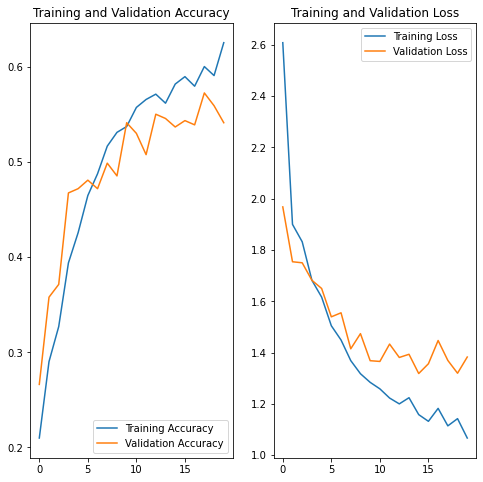

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?


### Findings:
- Data augmentation performed worse than model without agumentation and dropouts 
- This model is still an underfit

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

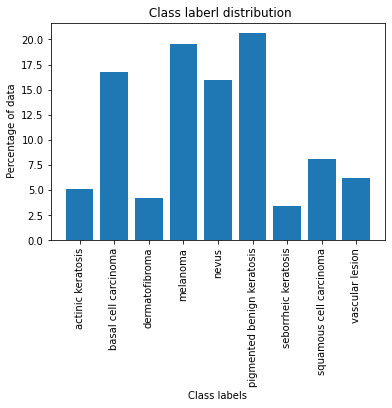

In [28]:
## Your code goes here.

# Look at the data imbalance
class_count = list(range(9))
for classess in range(9):
  imagepath = class_names[classess]+'/*' # prepare the search string for glob function
  class_count[classess] = len(list(data_dir_train.glob(imagepath))) # get the count of the each classes and store it in a list

class_dist = list(map(lambda x:100*x/sum(class_count),class_count)) # calculate the percentage distribution
temp_dict = {'label':class_names,'data distribution':class_dist}
class_dist_df = pd.DataFrame(data = temp_dict) # create a datafrom of the class distribution

# plot the graph
plt.bar(x=class_dist_df["label"],height=class_dist_df["data distribution"])
plt.title(" Class laberl distribution")
plt.ylabel(" Percentage of data")
plt.xlabel("Class labels")
plt.xticks(rotation=90)
plt.show()


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
- "seborrheic keratosis" has the lest number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
- "melanoma" and "pigmented benign keratosis" dominate the class distribution

## Findings
- "seborrheic keratosis", "dermatofibroma", "actinic keratosis", "squamous cell carcinoma" and "vascular lesion" has the least samples
- "melanoma","nevus", "pigmented benign keratosis" and "basal cell carcinoma" has the greater samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
data_dir_train

PosixPath('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [31]:
## original_df is expected in the starter code. I have used a different method to demonstate the class distribution in the original data set
# Therefore, below peice of code is added to generate the original_df to retain the started code
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/Skin cancer ISIC The International Sk...,squamous cell carcinoma
1,/content/Skin cancer ISIC The International Sk...,squamous cell carcinoma
2,/content/Skin cancer ISIC The International Sk...,squamous cell carcinoma
3,/content/Skin cancer ISIC The International Sk...,squamous cell carcinoma
4,/content/Skin cancer ISIC The International Sk...,squamous cell carcinoma
...,...,...
2234,/content/Skin cancer ISIC The International Sk...,pigmented benign keratosis
2235,/content/Skin cancer ISIC The International Sk...,pigmented benign keratosis
2236,/content/Skin cancer ISIC The International Sk...,pigmented benign keratosis
2237,/content/Skin cancer ISIC The International Sk...,pigmented benign keratosis


In [32]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F841015CC70>: 100%|██████████| 500/500 [00:21<00:00, 22.90 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F83B6110580>: 100%|██████████| 500/500 [00:20<00:00, 23.86 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F839C572670>: 100%|██████████| 500/500 [00:16<00:00, 30.42 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F839D714BE0>: 100%|██████████| 500/500 [01:23<00:00,  6.01 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=824x719 at 0x7F839D29F130>: 100%|██████████| 500/500 [01:24<00:00,  5.90 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F839EDA2AC0>: 100%|██████████| 500/500 [00:16<00:00, 29.84 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F839EF729D0>: 100%|██████████| 500/500 [00:40<00:00, 12.30 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F839D72E880>: 100%|██████████| 500/500 [00:22<00:00, 22.31 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F839D0D8040>: 100%|██████████| 500/500 [00:16<00:00, 30.59 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [34]:
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029567.jpg_a7d95850-6ead-442b-b04a-55ace6f2ad83.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0024923.jpg_2e0fa98a-ee5e-49c6-97d0-a1acf639d20e.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030280.jpg_b512def8-68d3-4c92-9f6a-6c186a3df983.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025264.jpg_8d7a3bd2-a218-43a5-b25d-e94c4daf1b84.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027294.jpg_d822d69f-98ff-4c9f-8331-2deb

In [35]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [36]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [37]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)
new_df

,Path,Label
0,/content/Skin cancer ISIC The International Sk...,squamous cell carcinoma
1,/content/Skin cancer ISIC The International Sk...,squamous cell carcinoma
2,/content/Skin cancer ISIC The International Sk...,squamous cell carcinoma
3,/content/Skin cancer ISIC The International Sk...,squamous cell carcinoma
4,/content/Skin cancer ISIC The International Sk...,squamous cell carcinoma
...,...,...
4495,/content/Skin cancer ISIC The International Sk...,pigmented benign keratosis
4496,/content/Skin cancer ISIC The International Sk...,pigmented benign keratosis
4497,/content/Skin cancer ISIC The International Sk...,pigmented benign keratosis
4498,/content/Skin cancer ISIC The International Sk...,pigmented benign keratosis


In [38]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [39]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [40]:
data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode="categorical")

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [41]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode="categorical")

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [42]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

In [43]:
## your code goes here

## Retain the model configuration same as before image augmentation including the dropouts
data_balanced_model = Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(img_height, img_width,3))])

# a keras convolutional layer is called Conv2D
# note that the first layer needs to be told the input shape explicitly

# first conv layer
data_balanced_model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(img_height, img_width,3), padding = "same")) # input shape = (img_rows, img_cols, 1)

# second conv layer
data_balanced_model.add(Conv2D(32, kernel_size=(3, 3), 
                 activation='relu',padding = "same"))
data_balanced_model.add(MaxPooling2D(pool_size=(2, 2)))


# third conv layer
data_balanced_model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu',padding = "same"))
data_balanced_model.add(MaxPooling2D(pool_size=(2, 2)))
data_balanced_model.add(Dropout(0.25))

# flatten and put a fully connected layer
data_balanced_model.add(Flatten())

data_balanced_model.add(Dense(128, activation='relu')) # fully connected
data_balanced_model.add(Dropout(0.5))

# softmax layer
data_balanced_model.add(Dense(9, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [44]:
## your code goes here
data_balanced_model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [45]:
data_balanced_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

#### **Todo:**  Train your model

In [46]:
epochs = 30
## Your code goes here, use 50 epochs.
history = data_balanced_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 40s 84ms/step - loss: 2.0520 - accuracy: 0.2417 - val_loss: 1.5976 - val_accuracy: 0.3942
Epoch 2/30
169/169 [==============================] - 10s 56ms/step - loss: 1.6401 - accuracy: 0.3741 - val_loss: 1.5742 - val_accuracy: 0.4402
Epoch 3/30
169/169 [==============================] - 9s 56ms/step - loss: 1.4443 - accuracy: 0.4605 - val_loss: 1.3333 - val_accuracy: 0.4811
Epoch 4/30
169/169 [==============================] - 10s 57ms/step - loss: 1.2692 - accuracy: 0.5265 - val_loss: 1.1232 - val_accuracy: 0.5702
Epoch 5/30
169/169 [==============================] - 10s 57ms/step - loss: 1.2014 - accuracy: 0.5532 - val_loss: 1.0401 - val_accuracy: 0.6177
Epoch 6/30
169/169 [==============================] - 10s 57ms/step - loss: 1.0421 - accuracy: 0.6191 - val_loss: 0.9429 - val_accuracy: 0.6570
Epoch 7/30
169/169 [==============================] - 10s 58ms/step - loss: 0.9699 - accuracy: 0.6465 - val_loss: 0.9718 - val_accuracy: 

#### **Todo:**  Visualize the model results

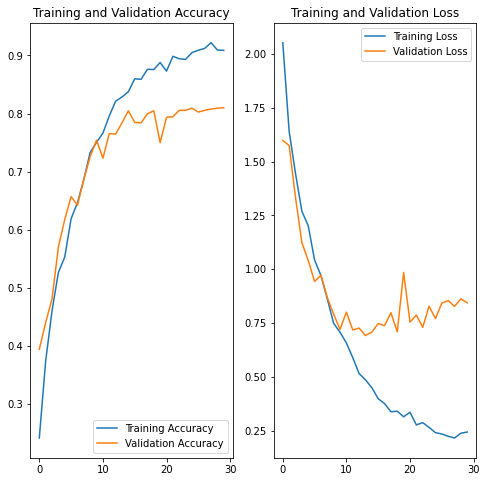

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

## Findings:
- Model performance improved significantly compared to all the other model interms of accuracy metrics

- Dropout and class impbalance handling helped acheiving good acurancy metrics on training and validation dataset



In [97]:
# check on the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                               batch_size=batch_size,
                                                               image_size=(img_height,img_width),
                                                               seed=123, 
                                                               validation_split = None,
                                                               subset= None,
                                                               label_mode='categorical',)

Found 118 files belonging to 9 classes.


In [98]:
model.evaluate(test_ds)

4/4 [==============================] - 3s 26ms/step - loss: 4.3140 - accuracy: 0.3220


[4.314043045043945, 0.32203391194343567]

In [99]:
data_augmentation_model.evaluate(test_ds)

4/4 [==============================] - 3s 26ms/step - loss: 2.3969 - accuracy: 0.3644


[2.396944046020508, 0.3644067943096161]

In [100]:
data_balanced_model.evaluate(test_ds)

4/4 [==============================] - 3s 28ms/step - loss: 6.4614 - accuracy: 0.2966


[6.46138334274292, 0.29661017656326294]

### Observation: 
- Surprisingly!! Model "without augmentation + dropout" and model "data balancing + dropout" are performing similarly poor in relation to the model with "augmentation + dropout"

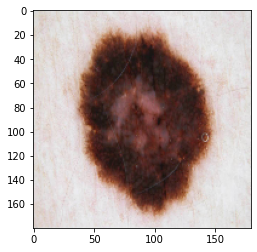

In [101]:
## Lets test on a particular image
test_image_path = os.path.join(data_dir_test,class_names[3],'*')
test_image = glob.glob(test_image_path)
test_image = tf.keras.preprocessing.image.load_img(test_image[9],target_size=(180,180,3))
plt.imshow(test_image)

In [102]:
img=np.expand_dims(test_image,axis=0)
prediction = model.predict(img)
pred = np.argmax(prediction)
predicted_class = class_names[pred]
print("Actual class: " + class_names[3])
print("Predicted class:" + predicted_class)

1/1 [==============================] - 0s 17ms/step
Actual class: melanoma
Predicted class:melanoma


In [103]:
img=np.expand_dims(test_image,axis=0)
prediction = data_augmentation_model.predict(img)
pred = np.argmax(prediction)
predicted_class = class_names[pred]
print("Actual class: " + class_names[3])
print("Predicted class:" + predicted_class)

1/1 [==============================] - 0s 17ms/step
Actual class: melanoma
Predicted class:melanoma


In [104]:
img=np.expand_dims(test_image,axis=0)
prediction = data_balanced_model.predict(img)
pred = np.argmax(prediction)
predicted_class = class_names[pred]
print("Actual class: " + class_names[3])
print("Predicted class:" + predicted_class)

1/1 [==============================] - 0s 17ms/step
Actual class: melanoma
Predicted class:melanoma


### All the models predicted a randomly selected malanoma class